### Quantization Aware Training With Pruning



In [1]:
import tensorflow as tf
from tensorflow.python.ops import array_ops, math_ops      #for math operations division_no_nan
from tensorflow.keras.layers import *

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from sklearn.metrics import roc_curve, auc

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

from qkeras import *
import hls4ml
from hls4ml.model.profiling import numerical, activations_keras, boxplot

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['font.size'] = 16.0

seed = 48

np.random.seed(seed)
tf.random.set_seed(seed)

import os
import sys

# will need to clone https://github.com/kpidgeon/cms-l1-triggers for a few
# helper functions if running notebook and include path to repo here
sys.path.append('/usersc/bz18310/previous_notebook/cms-l1-triggers')

from utils.analysis import eff_rate, optimal_eff_rate
from utils.preprocessing import resize
from utils.plotting import *
from utils.hls4ml_helpers import *

plt.rc('figure', figsize=(8,6))

In [2]:
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
  }

In [3]:
pq_model = tf.keras.Sequential()

pq_model.add(tfmot.sparsity.keras.prune_low_magnitude(QConv2D(4, kernel_size = (3,3),
                                                              kernel_quantizer=quantized_bits(5), 
                                                              bias_quantizer=quantized_bits(5)),
                                                    input_shape=(20,12,1) ,**pruning_params))
pq_model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
pq_model.add(BatchNormalization(axis=1))
pq_model.add(QActivation('quantized_relu(5)'))

pq_model.add(tfmot.sparsity.keras.prune_low_magnitude(QConv2D(8, kernel_size = (3,3), 
                                                              kernel_quantizer=quantized_bits(5), 
                                                              bias_quantizer=quantized_bits(5)),
            input_shape=(20,12,1) ,**pruning_params))
pq_model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
pq_model.add(BatchNormalization(axis=1))
pq_model.add(QActivation('quantized_relu(5)'))

pq_model.add(Flatten())
pq_model.add(tfmot.sparsity.keras.prune_low_magnitude(QDense(24, kernel_quantizer=quantized_bits(5), 
                                                              bias_quantizer=quantized_bits(5)),
                                                      **pruning_params))
pq_model.add(BatchNormalization(axis=1))
pq_model.add(QActivation('quantized_relu(5)'))

pq_model.add(tfmot.sparsity.keras.prune_low_magnitude(QDense(1, kernel_quantizer=quantized_bits(5), 
                                                              bias_quantizer=quantized_bits(5)),
                                                      **pruning_params))
pq_model.add(BatchNormalization(axis=1))
pq_model.add(Activation('sigmoid'))

pq_model.summary()



/software/bz18310/miniconda/envs/test_python_3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_q_conv2d (None, 18, 10, 4)         78        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 5, 4)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 5, 4)           36        
_________________________________________________________________
q_activation (QActivation)   (None, 9, 5, 4)           0         
_________________________________________________________________
prune_low_magnitude_q_conv2d (None, 7, 3, 8)           586       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 1, 8)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 1, 8)           1

In [4]:
push = lambda x: x > .5       #function to check if number greater than .5

def hls_model_accuracy(hls_model, test_X, test_y):                              #function for testing accurcry of hls model
    return accuracy_score(test_y, [push(i) for i in hls_model.predict(test_X)])

def get_timing(build_result):
    return (build_result['BestLatency'], build_result['WorstLatency'],
            build_result['IntervalMin'], build_result['IntervalMax'])


class CustomSensitivityAtSpecificity(tf.keras.metrics.SensitivityAtSpecificity):     #specificity TN/(TN+FP) 
                                                                                
    def __init__(self, specificity, num_thresholds=200, name=None, dtype=None):
        if specificity < 0 or specificity > 1:
            raise ValueError('`specificity` must be in the range [0, 1].')
        self.specificity = specificity
        self.num_thresholds = num_thresholds
        super().__init__(
            specificity, num_thresholds=num_thresholds, name=name, dtype=dtype)  #from the tf.kera.metrics.SensitivityAtSpecificity
                                                                                 #class, creates out object
    def result(self):
        specificities = math_ops.div_no_nan(
        self.true_negatives, self.true_negatives + self.false_positives)   #from keras class super()
        sensitivities = math_ops.div_no_nan(
        self.true_positives, self.true_positives + self.false_negatives)   
        return self._find_max_under_constraint(
                    specificities, sensitivities, math_ops.greater_equal)  #What?

    def get_threshold(self):
        specificities = math_ops.div_no_nan(
        self.true_negatives, self.true_negatives + self.false_positives)
        
        sensitivities = math_ops.div_no_nan(
        self.true_positives, self.true_positives + self.false_negatives)    #Sensitivity TP/(TP+FN)
        
        specs_above_thresh = array_ops.where(math_ops.greater_equal(specificities, self.value))   #What?
        
        return math_ops.reduce_min(array_ops.gather(self.thresholds, specs_above_thresh)).numpy()

def compiler(model_name):
    opt = tf.keras.optimizers.Adam(0.001)
    sensitivity_metric = tf.keras.metrics.SensitivityAtSpecificity(name='sens_at_spec',
                                                                             specificity=0.99925,     
                                                                             num_thresholds=20000)     
    auc_metric = tf.keras.metrics.AUC(name='auc', num_thresholds=200)   
    metrics = ['accuracy', sensitivity_metric, auc_metric]

    model_name.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)
    
    return model_name
       
def trainer(model_name, train_X, train_y):     

    model_name.fit(train_X, 
               train_y, 
               epochs=50, 
               verbose=1,
               batch_size=512, 
               validation_split=.2,   
               shuffle=True,
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                             patience=5,
                                                             restore_best_weights=True),     
                            pruning_callbacks.UpdatePruningStep()])
    
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

In [5]:
pq_model = compiler(pq_model)

In [6]:
data = np.load('./data_hh4b_20x12_160000.npz')
train_X = data['train_X']      #data for training the quantized model
train_y = data['train_y']      #data labels
test_X = data['test_X']
test_y = data['test_y']
test_X_hw_hh4b = data['test_X_hw_hh4b']
test_y_hw_hh4b = data['test_y_hw_hh4b']
test_X_hw_snu = data['test_X_hw_snu']
test_y_hw_snu = data['test_y_hw_snu']
data = 0

In [7]:
trainer(pq_model, train_X, train_y)

Epoch 1/50
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
188/188 [==============================] - 23s 101ms/step - loss: 0.3408 - accuracy: 0.9497 - sens_at_spec: 0.0386 - auc: 0.9813 - val_loss: 0.6619 - val_accuracy: 0.5977 - val_sens_at_spec: 0.4176 - val_auc: 0.9202
Epoch 2/50
188/188 [==============================] - 18s 95ms/step - loss: 0.2929 - accuracy: 0.9584 - sens_at_spec: 0.1453 - auc: 0.9873 - val_loss: 0.5280 - val_accuracy: 0.7482 - val_sens_at_spec: 0.4591 - val_auc: 0.9565
Epoch 3/50
188/188 [==============================] - 18s 94ms/step - loss: 0.2591 - accuracy: 0.9611 - sens_at_spec: 0.1657 - auc: 0.9886 - val_loss: 0.3054 - val_accuracy: 0.9083 - val_sens_at_spec: 0.4618 - val_auc: 0.9848
Epoch 4/50
188/188 [==============================] - 14s 73ms/step - loss: 0.2312 - accuracy: 0.9636 - sens_at_spec: 0.1622 - auc: 0.9898 - val_loss: 0.2875 - val_accuracy: 0.9127 - 

In [8]:
print_model_weights_sparsity(pq_model)

prune_low_magnitude_q_conv2d/kernel:0: 50.00% sparsity  (18/36)
prune_low_magnitude_q_conv2d/bias:0: 0.00% sparsity  (0/4)
batch_normalization/gamma:0: 0.00% sparsity  (0/9)
batch_normalization/beta:0: 11.11% sparsity  (1/9)
batch_normalization/moving_mean:0: 0.00% sparsity  (0/9)
batch_normalization/moving_variance:0: 0.00% sparsity  (0/9)
prune_low_magnitude_q_conv2d_1/kernel:0: 50.00% sparsity  (144/288)
prune_low_magnitude_q_conv2d_1/bias:0: 0.00% sparsity  (0/8)
batch_normalization_1/gamma:0: 0.00% sparsity  (0/3)
batch_normalization_1/beta:0: 0.00% sparsity  (0/3)
batch_normalization_1/moving_mean:0: 0.00% sparsity  (0/3)
batch_normalization_1/moving_variance:0: 0.00% sparsity  (0/3)
prune_low_magnitude_q_dense/kernel:0: 50.00% sparsity  (288/576)
prune_low_magnitude_q_dense/bias:0: 0.00% sparsity  (0/24)
batch_normalization_2/gamma:0: 0.00% sparsity  (0/24)
batch_normalization_2/beta:0: 0.00% sparsity  (0/24)
batch_normalization_2/moving_mean:0: 0.00% sparsity  (0/24)
batch_norm

In [9]:
model = tf.keras.models.load_model('./cnn_20x12_keras_trained')
model = compiler(model)

In [10]:
model.evaluate(test_X, test_y)
pq_model.evaluate(test_X, test_y)

1250/1250 [==============================] - 6s 4ms/step - loss: 0.0966 - accuracy: 0.9705 - sens_at_spec: 0.6012 - auc: 0.9953


[0.09664982557296753,
 0.9704750180244446,
 0.6012461185455322,
 0.9952586889266968]

In [11]:
def plot_roc_and_eff(model_list, model_name_list):
    bg_rate = 40*10**6
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots(figsize=(6,6))
    for i,m in enumerate(model_list):
        fpr, tpr, thresholds = roc_curve(test_y, m.predict(test_X))
        
        rates, rates_errs, effs, effs_errs = eff_rate(fpr, tpr, thresholds, 
                                                      bg_rate, 
                                                      test_y, 
                                                      m.predict(test_X))
        effs, rates, effs_errs, rates_errs = optimal_eff_rate(effs, rates, effs_errs, rates_errs)
        
        plot_roc(ax1, fpr, tpr, legend=True, label=model_name_list[i], lw=3.)
        plot_eff_rate(ax2, np.array(effs), np.array(rates), 
                      rates_errs=rates_errs, effs_errs=effs_errs, ls='', capsize=4., legend=True, label=model_name_list[i])
    
    ax1.plot([0,1], [0,1], ls='--', lw=2., color='black')
    ax1.set_yscale('log')
    ax1.set_ylim(0.000000001, 10)
    ax1.set_xscale('log')
    ax1.set_xlim(0.000000001, 10)
    
    ax2.set_xscale('log')
    ax2.set_xlim((1,1000))

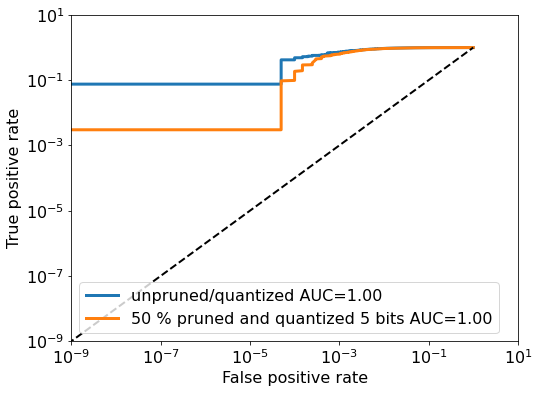

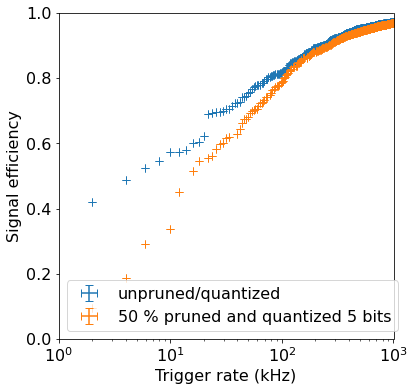

In [12]:
plot_roc_and_eff([model, pq_model], ['unpruned/quantized', '50 % pruned and quantized 5 bits'])

In [38]:
def hls4ml_converter_quantized(model_name, converted_dir, stripping):   #not sure ill use this...
    
    if stripping:
        model_name = strip_pruning(model_name)
    
    hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']      #What does this do?
    hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
    hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

    config = hls4ml.utils.config_from_keras_model(model_name, granularity='name')   #hls4ml get config from kera config
    """
    config = {'Model': {'Precision': 'ap_fixed<5,1>',
              'ReuseFactor': 1,
              'Strategy': 'Latency'}}
    """
    for l in config['LayerName']:
        config['LayerName'][l]['Strategy'] = 'Latency'
    config['LayerName']['activation']['exp_table_t'] = 'ap_fixed<18,8>'
    config['LayerName']['activation']['inv_table_t'] = 'ap_fixed<18,4>'
    

    display(config)
    hls_model = hls4ml.converters.convert_from_keras_model(model_name,
                                                       hls_config=config,   #set configuration of model
                                                       output_dir=converted_dir,  #6bit model save
                                                       fpga_part='xcku15p-ffva1760-2-e',     #What?
                                                        clock_period=(1/.24),      #set clock period??
                                                          io_type='io_stream')     #What?
    hls_model.compile()   #compiles model
    return hls_model
        

def hls4ml_converter(model_name, directory, stripping):
    if stripping:
        model_name = strip_pruning(model_name)
        
    config = hls4ml.utils.config_from_keras_model(model_name, granularity='model')
    config = {'Model': {'Precision': 'ap_fixed<5,1>',
              'ReuseFactor': 1,
              'Strategy': 'Latency'}}
    print("-----------------------------------")
    print("Configuration")
    display(config)
    print("-----------------------------------")
    hls_model = hls4ml.converters.convert_from_keras_model(model_name,
                                                           hls_config=config,   #set configuration of model
                                                           output_dir=directory,  #6bit model save
                                                           fpga_part='xcku15p-ffva1760-2-e',     #What?
                                                            clock_period=(1/.24),      #set clock period??
                                                              io_type='io_stream')     #
    hls_model.compile()
    return hls_model

In [39]:
hls4ml_pq_model = hls4ml_converter_quantized(pq_model, 'pruning_models/hls_qpruned/hls4ml_prj', stripping=True)

Interpreting Sequential
Topology:
Layer name: prune_low_magnitude_q_conv2d_input, layer type: Input
Layer name: q_conv2d, layer type: QConv2D
Layer name: max_pooling2d, layer type: MaxPooling2D
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: q_activation, layer type: QActivation
Layer name: q_conv2d_1, layer type: QConv2D
Layer name: max_pooling2d_1, layer type: MaxPooling2D
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: q_activation_1, layer type: QActivation
Layer name: q_dense, layer type: QDense
Layer name: batch_normalization_2, layer type: BatchNormalization
Layer name: q_activation_2, layer type: QActivation
Layer name: q_dense_1, layer type: QDense
Layer name: batch_normalization_3, layer type: BatchNormalization
Layer name: activation, layer type: Activation


{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 1,
  'Strategy': 'Latency'},
 'LayerName': {'prune_low_magnitude_q_conv2d_input': {'Precision': {'result': 'ap_fixed<16,6>'},
   'Strategy': 'Latency'},
  'q_conv2d': {'Precision': {'weight': 'ap_fixed<6,1>',
    'bias': 'ap_fixed<6,1>'},
   'ReuseFactor': 1,
   'Strategy': 'Latency'},
  'max_pooling2d': {'Precision': 'ap_fixed<16,6>', 'Strategy': 'Latency'},
  'batch_normalization': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1,
   'Strategy': 'Latency'},
  'q_activation': {'Precision': {'result': 'ap_fixed<6,1>'},
   'ReuseFactor': 1,
   'Strategy': 'Latency'},
  'q_conv2d_1': {'Precision': {'weight': 'ap_fixed<6,1>',
    'bias': 'ap_fixed<6,1>'},
   'ReuseFactor': 1,
   'Strategy': 'Latency'},
  'max_pooling2d_1': {'Precision': 'ap_fixed<16,6>', 'Strategy': 'Latency'},
  'batch_normalization_1': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFa

Interpreting Sequential
Topology:
Layer name: prune_low_magnitude_q_conv2d_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: q_conv2d, layer type: QConv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Name: quantized_relu
Layer name: q_activation, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: q_conv2d_1, layer type: QConv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 18, 10, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 9, 5, 8]]
Name: quantized_relu
Layer name: q_activation_1, layer type: Activation, current shape: [[None, 9, 5, 8]]
Layer name: q_dense, layer type: QDense, current shape: [[None, 9, 5, 8]]
Layer name: batch_normalization_2, layer 

ValueError: Integers to negative integer powers are not allowed.

In [ ]:
from qkeras.utils import load_qmodel

qmodel = load_qmodel('./pruning_models/qmodel_unpruned_train_1_test.h5')
qmodel.summary()

In [22]:
hls4ml_qmodel = hls4ml_converter_quantized(qmodel, 'pruning_models/hls_test/hls4ml_prj', stripping=True)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: Input
Layer name: conv1, layer type: QConv2D
Layer name: max_pooling2d, layer type: MaxPooling2D
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: relu_c1, layer type: QActivation
Layer name: conv2, layer type: QConv2D
Layer name: max_pooling2d_1, layer type: MaxPooling2D
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: relu_c2, layer type: QActivation
Layer name: dense1, layer type: QDense
Layer name: batch_normalization_2, layer type: BatchNormalization
Layer name: relu1, layer type: QActivation
Layer name: output, layer type: QDense
Layer name: batch_normalization_3, layer type: BatchNormalization
Layer name: sigmoid, layer type: Activation


{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 1,
  'Strategy': 'Latency'},
 'LayerName': {'conv1_input': {'Precision': {'result': 'ap_fixed<16,6>'},
   'Strategy': 'Latency'},
  'conv1': {'Precision': {'weight': 'ap_fixed<6,1>'},
   'ReuseFactor': 1,
   'Strategy': 'Latency'},
  'max_pooling2d': {'Precision': 'ap_fixed<16,6>', 'Strategy': 'Latency'},
  'batch_normalization': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1,
   'Strategy': 'Latency'},
  'relu_c1': {'Precision': {'result': 'ap_fixed<6,1>'},
   'ReuseFactor': 1,
   'Strategy': 'Latency'},
  'conv2': {'Precision': {'weight': 'ap_fixed<6,1>'},
   'ReuseFactor': 1,
   'Strategy': 'Latency'},
  'max_pooling2d_1': {'Precision': 'ap_fixed<16,6>', 'Strategy': 'Latency'},
  'batch_normalization_1': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1,
   'Strategy': 'Latency'},
  'relu_c2': {'Precision': {'result': 'ap_fixed<6,1>'},
 

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: QConv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Name: quantized_relu
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: QConv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Name: quantized_relu
Layer name: relu_c2, layer type: Activation, current shape: [[None, 3, 1, 8]]
Layer name: dense1, layer type: QDense, current shape: [[None, 3, 1, 8]]
Layer name: batch_normalization_2, layer type: BatchNormalization, current shape: [[None,

Done


In [23]:
hls4ml_qmodel.build(csim=False)

{'EstimatedClockPeriod': '3.646',
 'BestLatency': '288',
 'WorstLatency': '288',
 'IntervalMin': '247',
 'IntervalMax': '247',
 'BRAM_18K': '18',
 'DSP48E': '13',
 'FF': '10479',
 'LUT': '42727',
 'URAM': '0',
 'AvailableBRAM_18K': '1968',
 'AvailableDSP48E': '1968',
 'AvailableFF': '1045440',
 'AvailableLUT': '522720',
 'AvailableURAM': '128'}

In [24]:
hls4ml.report.read_vivado_report('pruning_models/hls_test/hls4ml_prj')

Found 1 solution(s) in pruning_models/hls_test/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Mon Jul 26 12:12:50 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexuplus
* Target device:  xcku15p-ffva1760-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 4.17 ns | 3.646 ns |   0.52 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline |
    |   min   |   max   |    min   |    max   | min | max |   Type   |
    +---------+----